# Brain Tumour Detection with data science

In [1]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from IPython.core.display import Image

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import random
import os
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
train_dir = 'G:\Training'
test_dir = 'G:\Testing'
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+'/'+label):
        train_paths.append(train_dir+'/'+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

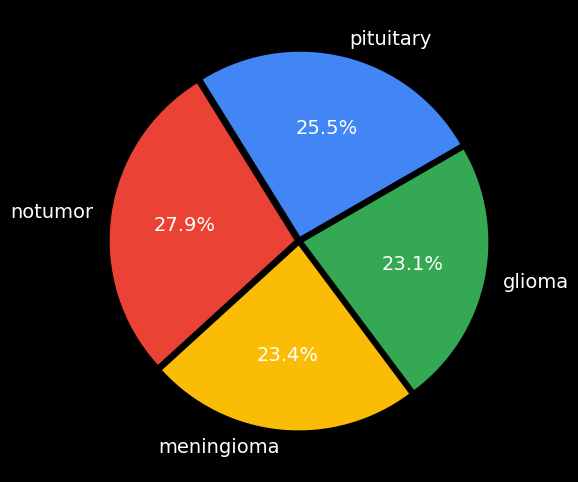

In [3]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

In [4]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+'/'+label):
        test_paths.append(test_dir+'/'+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

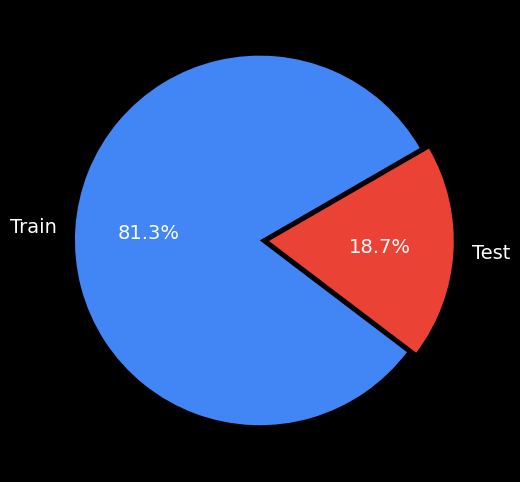

In [5]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [6]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

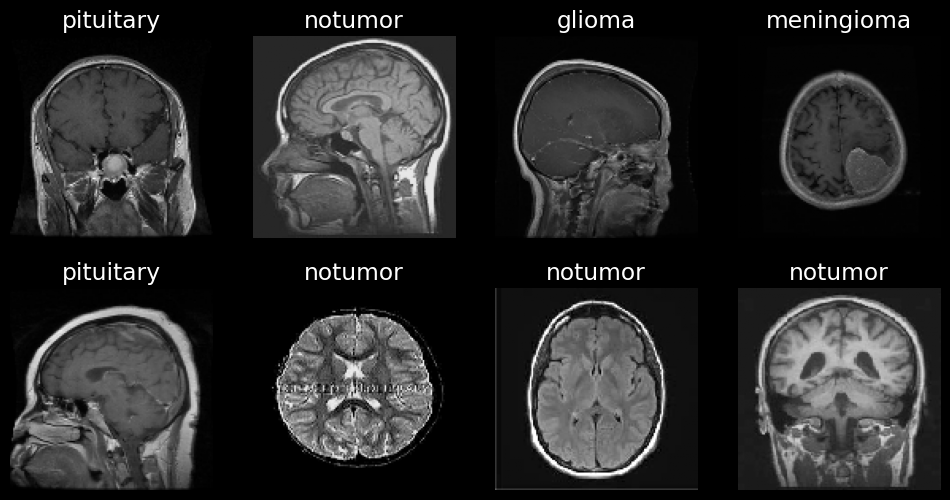

In [7]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [8]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [9]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [10]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
Non

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [12]:
batch_size = 20
steps = 100
epochs = 5
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
100/100 [==============================] - 1919s 19s/step - loss: 0.5925 - sparse_categorical_accuracy: 0.7630
Epoch 2/5
100/100 [==============================] - 1664s 17s/step - loss: 0.3838 - sparse_categorical_accuracy: 0.8580
Epoch 3/5
100/100 [==============================] - 45719s 462s/step - loss: 0.3133 - sparse_categorical_accuracy: 0.8835
Epoch 4/5
100/100 [==============================] - 1287s 13s/step - loss: 0.2514 - sparse_categorical_accuracy: 0.8975
Epoch 5/5
100/100 [==============================] - 1279s 13s/step - loss: 0.2185 - sparse_categorical_accuracy: 0.9175


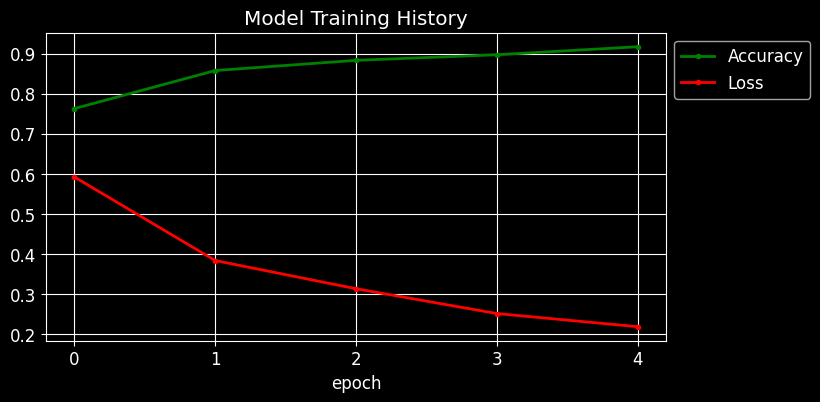

In [13]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [14]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 25s 25s/step


  2%|██                                                                                 | 1/40 [00:34<22:31, 34.64s/it]

1/1 [==============================] - 17s 17s/step


  5%|████▏                                                                              | 2/40 [00:53<16:01, 25.29s/it]

1/1 [==============================] - 17s 17s/step


  8%|██████▏                                                                            | 3/40 [01:12<13:52, 22.49s/it]

1/1 [==============================] - 17s 17s/step


 10%|████████▎                                                                          | 4/40 [01:31<12:34, 20.97s/it]

1/1 [==============================] - 17s 17s/step


 12%|██████████▍                                                                        | 5/40 [01:50<11:50, 20.31s/it]

1/1 [==============================] - 17s 17s/step


 15%|████████████▍                                                                      | 6/40 [02:08<11:11, 19.75s/it]

1/1 [==============================] - 17s 17s/step


 18%|██████████████▌                                                                    | 7/40 [02:27<10:37, 19.32s/it]

1/1 [==============================] - 17s 17s/step


 20%|████████████████▌                                                                  | 8/40 [02:45<10:10, 19.07s/it]

1/1 [==============================] - 17s 17s/step


 22%|██████████████████▋                                                                | 9/40 [03:04<09:46, 18.93s/it]

1/1 [==============================] - 17s 17s/step


 25%|████████████████████▌                                                             | 10/40 [03:22<09:22, 18.75s/it]

1/1 [==============================] - 17s 17s/step


 28%|██████████████████████▌                                                           | 11/40 [03:41<09:00, 18.65s/it]

1/1 [==============================] - 17s 17s/step


 30%|████████████████████████▌                                                         | 12/40 [03:59<08:41, 18.62s/it]

1/1 [==============================] - 17s 17s/step


 32%|██████████████████████████▋                                                       | 13/40 [04:18<08:23, 18.63s/it]

1/1 [==============================] - 17s 17s/step


 35%|████████████████████████████▋                                                     | 14/40 [04:37<08:05, 18.67s/it]

1/1 [==============================] - 17s 17s/step


 38%|██████████████████████████████▊                                                   | 15/40 [04:55<07:46, 18.67s/it]

1/1 [==============================] - 17s 17s/step


 40%|████████████████████████████████▊                                                 | 16/40 [05:14<07:27, 18.65s/it]

1/1 [==============================] - 17s 17s/step


 42%|██████████████████████████████████▊                                               | 17/40 [05:33<07:08, 18.65s/it]

1/1 [==============================] - 17s 17s/step


 45%|████████████████████████████████████▉                                             | 18/40 [05:51<06:49, 18.63s/it]

1/1 [==============================] - 17s 17s/step


 48%|██████████████████████████████████████▉                                           | 19/40 [06:10<06:31, 18.62s/it]

1/1 [==============================] - 17s 17s/step


 50%|█████████████████████████████████████████                                         | 20/40 [06:28<06:12, 18.61s/it]

1/1 [==============================] - 17s 17s/step


 52%|███████████████████████████████████████████                                       | 21/40 [06:47<05:53, 18.59s/it]

1/1 [==============================] - 17s 17s/step


 55%|█████████████████████████████████████████████                                     | 22/40 [07:05<05:33, 18.53s/it]

1/1 [==============================] - 17s 17s/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [07:24<05:16, 18.60s/it]

1/1 [==============================] - 17s 17s/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [07:43<04:58, 18.67s/it]

1/1 [==============================] - 17s 17s/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [08:01<04:39, 18.61s/it]

1/1 [==============================] - 17s 17s/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [08:20<04:20, 18.61s/it]

1/1 [==============================] - 17s 17s/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [08:39<04:02, 18.65s/it]

1/1 [==============================] - 17s 17s/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [08:57<03:42, 18.56s/it]

1/1 [==============================] - 17s 17s/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [09:16<03:23, 18.53s/it]

1/1 [==============================] - 17s 17s/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [09:34<03:05, 18.53s/it]

1/1 [==============================] - 17s 17s/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [09:53<02:46, 18.50s/it]

1/1 [==============================] - 17s 17s/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [10:11<02:27, 18.50s/it]

1/1 [==============================] - 17s 17s/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [10:29<02:09, 18.44s/it]

1/1 [==============================] - 17s 17s/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [10:48<01:50, 18.43s/it]

1/1 [==============================] - 17s 17s/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [11:06<01:32, 18.48s/it]

1/1 [==============================] - 17s 17s/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [11:25<01:13, 18.46s/it]

1/1 [==============================] - 17s 17s/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [11:43<00:55, 18.47s/it]

1/1 [==============================] - 17s 17s/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [12:02<00:36, 18.43s/it]

1/1 [==============================] - 17s 17s/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [12:20<00:18, 18.41s/it]

1/1 [==============================] - 17s 17s/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [12:39<00:00, 18.54s/it]

1/1 [==============================] - 17s 17s/step


41it [12:57, 18.97s/it]                                                                                                


In [15]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

      glioma       0.92      0.87      0.89       300
  meningioma       0.88      0.63      0.74       306
     notumor       0.87      0.99      0.92       405
   pituitary       0.85      0.99      0.91       300

    accuracy                           0.88      1311
   macro avg       0.88      0.87      0.87      1311
weighted avg       0.88      0.88      0.87      1311



In [16]:
def names(number):
    if number==0:
        return 'No, Its not a tumor'
    else:
        return 'Its a Tumor'

In [17]:
from PIL import Image


100.0% Conclusion: Its a Tumor


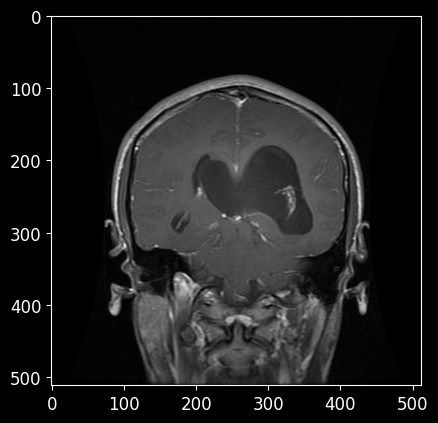

In [18]:
from matplotlib.pyplot import imshow
img = Image.open(r"G:/Training/glioma/Tr-glTr_0002.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Conclusion: ' + names(classification))

100.0% Conclusion: Its a Tumor


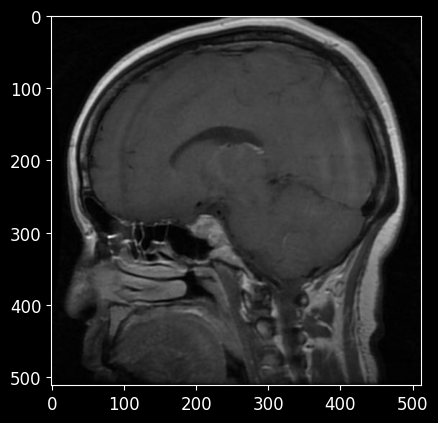

In [19]:
from matplotlib.pyplot import imshow
img = Image.open(r"G:/Testing/pituitary/Te-piTr_0004.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Conclusion: ' + names(classification))

100.0% Conclusion: Its a Tumor


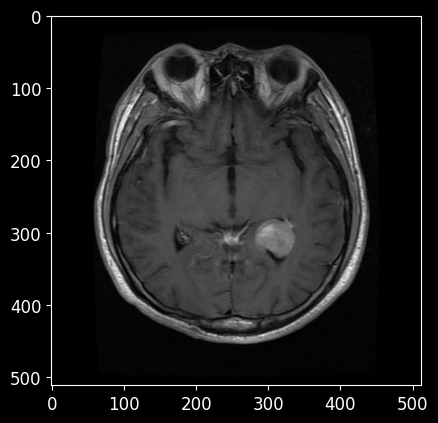

In [20]:
from matplotlib.pyplot import imshow
img = Image.open(r"G:/Training/meningioma/Tr-meTr_0001.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Conclusion: ' + names(classification))

100.0% Conclusion: No, Its not a tumor


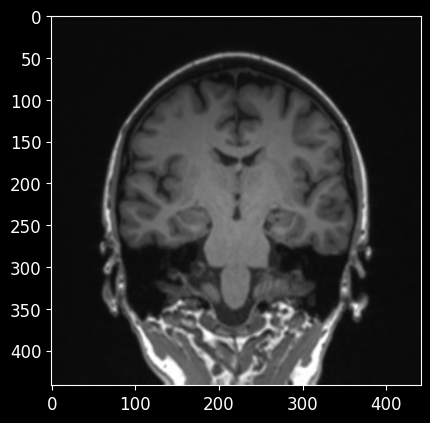

In [21]:
def names(number):
    if number==0:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'   
from matplotlib.pyplot import imshow
img = Image.open(r"G:/Training/notumor/Tr-noTr_0004.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Conclusion: ' + names(classification))